[LangGraph](https://www.langchain.com/langgraph)  

What we will do here, 
1. Simple graph with two nodes connected by edges to get started.
2. Build a basic chatbot
3. Enhancing the basic chatbot with tools

We will use [Ollama](https://ollama.com/) for LLM -> `llama 3.1:8b` for basic testing.  
If needed you can use other models too.

In [115]:
%%capture
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain-openai

In [116]:
from langgraph.graph import Graph

# define a langchain graph
graph_builder = Graph()

In [117]:
# lets first understand how the Graph things work here
# nodes act like functions that can be called as needed
def function_1(input_1):
    return input_1 + " Hi "

def function_2(input_2):
    return input_2 + "there"

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.
graph_builder.add_node("node_1", function_1)
graph_builder.add_node("node_2", function_2)

In [118]:
graph_builder.add_edge("node_1", "node_2")
graph_builder.set_entry_point("node_1")
graph_builder.set_finish_point("node_2")

In [119]:
graph = graph_builder.compile()

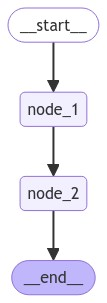

In [120]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [121]:
# now, lets run the chatbot
graph.invoke("Hello")

'Hello Hi there'

### Let's build a basic chatbot
[LangSmith](https://www.langchain.com/langsmith) -> Debug, collaborate, test, and monitor your LLM applications.

In [8]:
# langsmith makes it esier to see what's going on "under the hood"
# https://eu.smith.langchain.com
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [9]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_ENDPOINT"] = "https://eu.api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-tutorial"

>Important: Ollama now has built-in [compatibility](https://ollama.com/blog/openai-compatibility) with the OpenAI Chat Completions API, making it possible to use more tooling and applications with Ollama locally. If you want to use OpenAI, replace the api_key with OpenAI's.

In [122]:
from langchain_openai import ChatOpenAI

**Make sure Ollama is running -> http://localhost:11434**

In [123]:
llm_local = ChatOpenAI(api_key="provide_aynthing_here",model="llama3.1:8b",base_url="http://localhost:11434/v1",)

- Start by creating a `StateGraph`. 
- A `StateGraph` object defines the structure of our chatbot as a "state machine". 
- We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [124]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


So now our graph knows two things:

- Every `node` we define will receive the current State as input and return a value that updates that state.
- `messages` will be appended to the current list, rather than directly overwritten. This is communicated via the prebuilt add_messages function in the Annotated syntax.

Next, add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.

In [125]:
def chatbot(state: State):
    return {"messages": [llm_local.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

The `add_messages` function in our State will append the llm's response messages to whatever messages are already in the state.

In [126]:
# Next, add an entry point. This tells our graph where to start its work each time we run it.
graph_builder.add_edge(START, "chatbot")

In [127]:
# Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."
graph_builder.add_edge("chatbot", END)

In [128]:
# Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. 
# This creates a "CompiledGraph" we can use invoke on our state.
graph = graph_builder.compile()

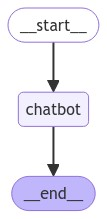

In [129]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [130]:
# now, lets run the chatbot
# Tip: You can exit the chat loop at any time by typing "quit", "exit", or "q".

while True:  # Start an infinite loop to keep the program running until a break condition is met.
    user_input = input("User: ")  # Prompt the user to input a message.
    
    # Check if the user wants to quit by typing "quit", "exit", or "q" (case-insensitive).
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # Print a goodbye message.
        break  # Exit the loop and end the program.
    
    # Stream events from the 'graph' using the user input, processing each event returned.
    for event in graph.stream({"messages": ("user", user_input)}):
        # Iterate over each value in the event.
        for value in event.values():
            # Print the assistant's response, which is the last message in the 'messages' list of the value.
            print("Assistant:", value["messages"][-1].content)


Assistant: Hello! How are you today? Is there something I can help with or would you like to chat?
Assistant: Helsinki, the capital city of Finland, has a temperate climate with cold winters and mild summers. Here's an overview of the typical weather conditions in Helsinki:

**Seasonal Weather Patterns:**

* **Winter (December to February):**
	+ Temperature: Average -3°C (27°F), with lows around -10°C (14°F) and highs around 0°C (32°F).
	+ Snowfall: Moderate, with an average of 35 cm (13.8 in) snow per month.
	+ Sunshine hours: Around 6-7 hours per day.
* **Spring (March to May):**
	+ Temperature: Gradually warming up, with averages ranging from 2°C (36°F) to 12°C (54°F).
	+ Precipitation: Increasing, but still relatively moderate, with an average of 3-5 rainy days per month.
	+ Sunshine hours: Around 10-14 hours per day.
* **Summer (June to August):**
	+ Temperature: Pleasant, with averages around 17°C (63°F) to 23°C (73°F).
	+ Precipitation: Relatively low, with an average of 1-2 rai

In [131]:
llm_local.invoke("hello world!")

AIMessage(content="HELLO WORLD! It's great to connect with you! Is there something I can help you with or would you like to chat?", response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 13, 'total_tokens': 41}, 'model_name': 'llama3.1:8b', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None}, id='run-e187570f-e94c-47d8-953c-64e0e4c40a19-0', usage_metadata={'input_tokens': 13, 'output_tokens': 28, 'total_tokens': 41})

##### bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

### Enhancing the Chatbot with Tools ( web search tool )

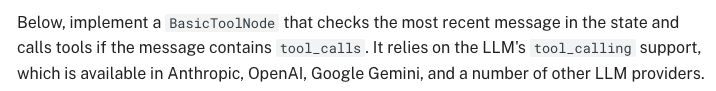

In [65]:
# _set_env("OPENAI_API_KEY")

In [102]:
#from langchain_openai import ChatOpenAI
#llm = ChatOpenAI(temperature=0, streaming=True)

In [132]:
%%capture
%pip install -U tavily-python
%pip install -U langchain_community

First, install the requirements to use the [Tavily Search Engine](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/), and set your TAVILY_API_KEY.

In [133]:
_set_env("TAVILY_API_KEY")

In [134]:
# lets define the tool

from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [137]:
tool.invoke("What is the weather of Helsinki in Celsius?")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Helsinki', 'region': 'Southern Finland', 'country': 'Finland', 'lat': 60.18, 'lon': 24.93, 'tz_id': 'Europe/Helsinki', 'localtime_epoch': 1723316729, 'localtime': '2024-08-10 22:05'}, 'current': {'last_updated_epoch': 1723316400, 'last_updated': '2024-08-10 22:00', 'temp_c': 15.1, 'temp_f': 59.2, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 11.0, 'wind_kph': 17.6, 'wind_degree': 250, 'wind_dir': 'WSW', 'pressure_mb': 1001.0, 'pressure_in': 29.56, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 78, 'cloud': 20, 'feelslike_c': 15.1, 'feelslike_f': 59.2, 'windchill_c': 15.1, 'windchill_f': 59.2, 'heatindex_c': 15.1, 'heatindex_f': 59.2, 'dewpoint_c': 11.3, 'dewpoint_f': 52.4, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 1.0, 'gust_mph': 20.0, 'gust_kph': 32.1}}"},
 {'url': 'https://world-weather.info/forecast/finland/helsinki/august-

In [139]:
llm_with_tools = llm_local.bind_tools(tools)

In [140]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

#llm = ChatOpenAI(temperature=0, streaming=True)
#llm = ChatAnthropic(model="claude-3-haiku-20240307")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm_local.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

**Create a function to actually run the tools if they are called**

In [141]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A class representing a node that processes and executes tool requests embedded in the last AI message."""

    def __init__(self, tools: list) -> None:
        """
        Initializes the BasicToolNode with a list of available tools.
        
        Args:
            tools (list): A list of tool objects that the node can use to execute requests.
        """
        # Creates a dictionary mapping tool names to tool objects for quick lookup during execution
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """
        Processes the input data to extract the latest message and execute the requested tools.
        
        Args:
            inputs (dict): A dictionary containing messages, where each message can contain tool calls.
        
        Returns:
            dict: A dictionary with a list of ToolMessage objects containing the results of tool executions.
        
        Raises:
            ValueError: If no messages are found in the input.
        """
        # Extracts the latest message from the input, raising an error if no messages are found
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # List to accumulate the outputs of each tool invocation
        outputs = []
        
        # Iterate over each tool call in the message, invoking the corresponding tool and collecting the results
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # Wraps the tool result in a ToolMessage object and appends it to the outputs list
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        
        # Returns a dictionary with the key "messages" containing the list of ToolMessage objects
        return {"messages": outputs}

# Example usage: Instantiating the BasicToolNode with a list of tools and adding it to a graph builder
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)


**Now, lets define the conditional edges**

In [142]:
from typing import Literal

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Determines the next node in the processing graph based on the last AI message in the state.
    
    This function is used in a conditional edge to decide whether to route the flow to the 'tools' node,
    if the last message contains tool calls, or to the '__end__' node if no tool calls are present.

    Args:
        state (State): The current state, which may be a list of messages or a dictionary containing messages.
    
    Returns:
        Literal["tools", "__end__"]: A string indicating the next node to route to. Returns "tools" if the last 
        message has tool calls, otherwise returns "__end__".
    
    Raises:
        ValueError: If no messages are found in the state.
    """
    # Checks if the state is a list, retrieves the last message; otherwise, tries to get it from a dictionary
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # If the last message contains tool calls, route to the "tools" node
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    
    # If no tool calls are found, route to the "__end__" node
    return "__end__"


# Conditional routing function to direct the flow based on the presence of tool calls in the last message
# The route_tools function will return "tools" if the AI message has tool calls, otherwise "__end__"
graph_builder.add_conditional_edges(
    "chatbot",  # The node from which the routing decision will be made
    route_tools,  # The function that determines the next node
    {
        # Mapping of function return values to specific nodes in the graph
        "tools": "tools",       # If the function returns "tools", route to the "tools" node
        "__end__": "__end__",   # If the function returns "__end__", route to the "__end__" node
    }
)

# Adding an edge to return to the chatbot node after any tool call to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Starting the graph by linking the START node to the chatbot node
graph_builder.add_edge(START, "chatbot")

# Compile the graph to finalize the structure and prepare it for execution
graph = graph_builder.compile()


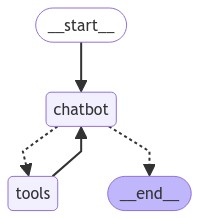

In [143]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [145]:
from langchain_core.messages import BaseMessage

# Start an infinite loop to continuously interact with the user
while True:
    # Prompt the user for input and capture their response
    user_input = input("User: ")
    
    # Check if the user wants to quit the interaction
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # Print a farewell message
        break  # Exit the loop, ending the program
    
    # Stream events from the graph using the user's input
    # The input is wrapped in a dictionary with "messages" key containing a list of tuples (message type, content)
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # Iterate over the values produced by each event in the stream
        for value in event.values():
            
            # Check if the last message in the list is an instance of BaseMessage
            if isinstance(value["messages"][-1], BaseMessage):
                
                # Print the content of the Assistant's response
                print("Assistant:", value["messages"][-1].content)


Assistant: 
Assistant: [{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Helsinki', 'region': 'Southern Finland', 'country': 'Finland', 'lat': 60.18, 'lon': 24.93, 'tz_id': 'Europe/Helsinki', 'localtime_epoch': 1723316925, 'localtime': '2024-08-10 22:08'}, 'current': {'last_updated_epoch': 1723316400, 'last_updated': '2024-08-10 22:00', 'temp_c': 15.1, 'temp_f': 59.2, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 11.0, 'wind_kph': 17.6, 'wind_degree': 250, 'wind_dir': 'WSW', 'pressure_mb': 1001.0, 'pressure_in': 29.56, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 78, 'cloud': 20, 'feelslike_c': 15.1, 'feelslike_f': 59.2, 'windchill_c': 15.1, 'windchill_f': 59.2, 'heatindex_c': 15.1, 'heatindex_f': 59.2, 'dewpoint_c': 11.3, 'dewpoint_f': 52.4, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 1.0, 'gust_mph': 20.0, 'gust_kph': 32.1}}"}, {"url": "https://world-weather.info/forecast/finl